# Exercise 1: Decision Tree Classifier (30 points)

In this exercise we will train a decision tree classifier for neutrino experiment data from [the MiniBOONE experiment](https://www.fnal.gov/pub/science/experiments/intensity/miniboone.html).

The goal is to prepare a binary classification to distinguish electron neutrinos (signal) from muon neutrinos (background). The dataset is taken from the UCI ML dataset repository.

In [43]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


data = fetch_openml("miniboone", parser="auto", version=1)
X, y = data["data"].values, (data["target"].values == "True").astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## part 1(a): Data Exploration and Visualization (10 points)

Explore the dataset before building your ML classifier:
- How many events are in the training data and testing data?
- How many input features are there for each point in the training data?
- Plot at least three of the input features for events with `y_train==0` and for events with `y_train==1`.

In [44]:
# Add code here to explore the dataset
print(f"Training features shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}, Testing labels shape: {y_test.shape}")


Training features shape: (104051, 50), Training labels shape: (104051,)
Testing features shape: (26013, 50), Testing labels shape: (26013,)


We can see that our training data consists of 104051 datapoints, which is 80% of the total data, where each datapoint is described by 50 features. The dataset for the training labels consists as well of 104051 datapoints since each input data needs an output. The output label here is one dimensional since this is a binary classification. Furthermore our testing data is 20% of the total data resulting in 26015 datapoints with each 50 features and similarily 26013 testing labels with one output. The whole dataset is given with 104051 + 26013  = 130064 datapoints.

In [45]:
# take a look at data values
print(y_train[1])
print(y_train[2])

print(len(X_train[0]))
print(X_train[0])
print(X_train[0][0])

1.0
0.0
50
[ 4.09724e+00  1.06346e+00  5.50024e+00  2.42023e-01  8.54701e-03
  4.46796e-01  1.45377e+00  8.56460e-01  3.38350e+00  1.94279e-01
  4.40352e+00  1.72699e+02  4.60198e-01  3.01134e-01  2.41283e+00
  1.03752e+03  5.51504e-01  6.75497e+00  2.94017e-01  1.38780e+00
 -4.18311e-02  2.75214e-01  1.05744e+02  4.54370e+00  4.58471e-01
 -1.98104e-01  1.73316e+02  1.27531e+00  2.00311e-01 -8.18247e-03
  5.36284e+00  1.32521e+00  5.89509e-01  3.77195e+02  1.16621e-01
  3.43302e-01  1.74317e+00 -3.72286e+00  1.25252e+00  8.97464e-02
  1.22217e+02 -8.80883e+00  6.00565e-01  3.98524e+00  0.00000e+00
  1.16346e-01 -1.22288e-03  1.16412e+00  2.64662e-01  2.10654e-01]
4.09724


In [46]:
def plot_features(training_input_data, training_output_data, feature_int, x_min, x_max):

  # accessing data with correct labels and desired feature
  x_data_label_0 = []
  x_data_label_1 = []
  for i in range(len(training_output_data)):
    if training_output_data[i] == 0.0:
      x_data_label_0.append(training_input_data[i][feature_int])
    elif training_output_data[i] == 1.0:
      x_data_label_1.append(training_input_data[i][feature_int])

  # Plot
  plt.figure(figsize=(6, 4))
  plt.hist(x_data_label_0, bins=50,range=(x_min, x_max), color='pink', label='Data with label 0')
  plt.hist(x_data_label_1, bins = 50,range=(x_min, x_max), color='purple', label='Data with label 1')
  plt.xlabel('Value of Feature')
  plt.xlim([x_min, x_max]) # there is one datapoint with a feature value of -1000, ignore that in plot
  plt.ylabel('Number of Events')
  plt.legend()
  plt.title(f"Feature Nr. {feature_int}")
  plt.show()



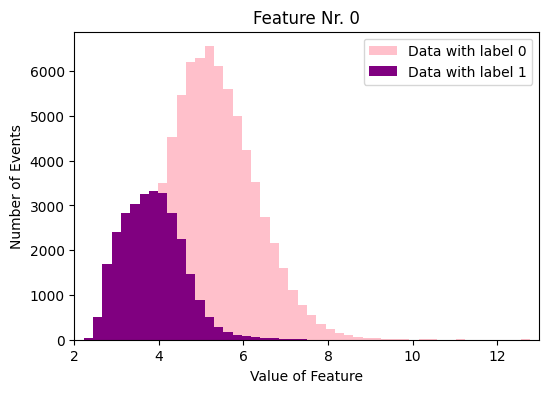

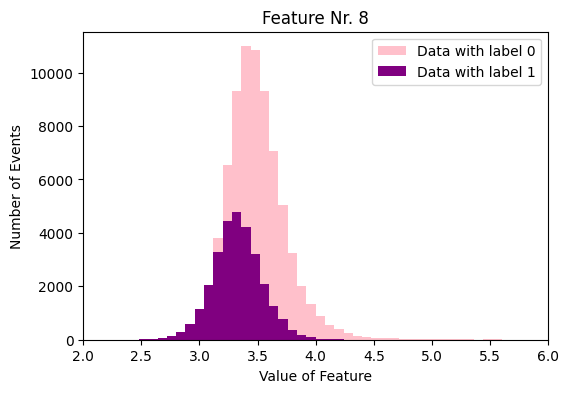

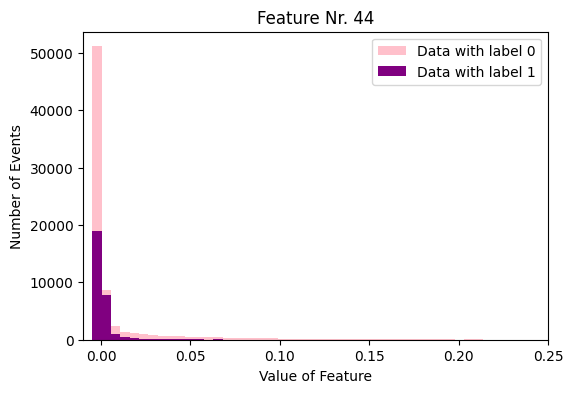

In [47]:
plot_features(X_train, y_train, 0, 2, 13)
plot_features(X_train, y_train, 8, 2, 6)
plot_features(X_train, y_train, 44, -0.01, 0.25)

## part 1(b): Decision Tree (10 points)

Train a simple `DecisionTreeClassifier` with `max_depth=5` and the `gini` criterion to separate the electron neutrino signal and muon neutrino background.

Calculate the performance of the Decision Tree:
- confusion matrix
- ROC curve
- Area Under Curve (AUC)


In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier,AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

import seaborn as sns
from sklearn.metrics import roc_curve, auc

from sklearn.tree import plot_tree


In [49]:
score=[]
dtclassifier = DecisionTreeClassifier(criterion='gini', max_depth=5)
dtclassifier.fit(X_train, y_train)
dtclassifier.score(X_train,y_train),dtclassifier.score(X_test,y_test)

(0.8940231232760858, 0.8912466843501327)

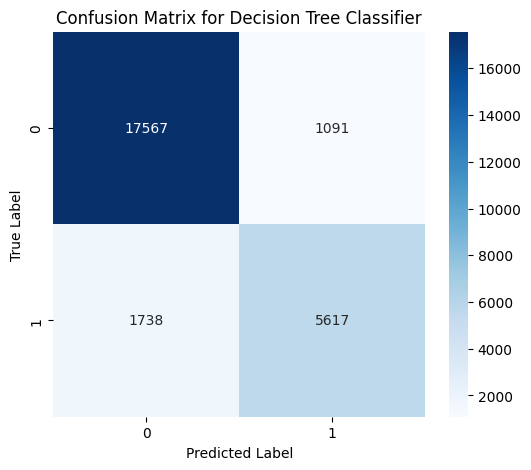

In [50]:
# Get predictions from the DecisionTreeClassifier on the test set
y_pred_dt = dtclassifier.predict(X_test)

# Create confusion matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

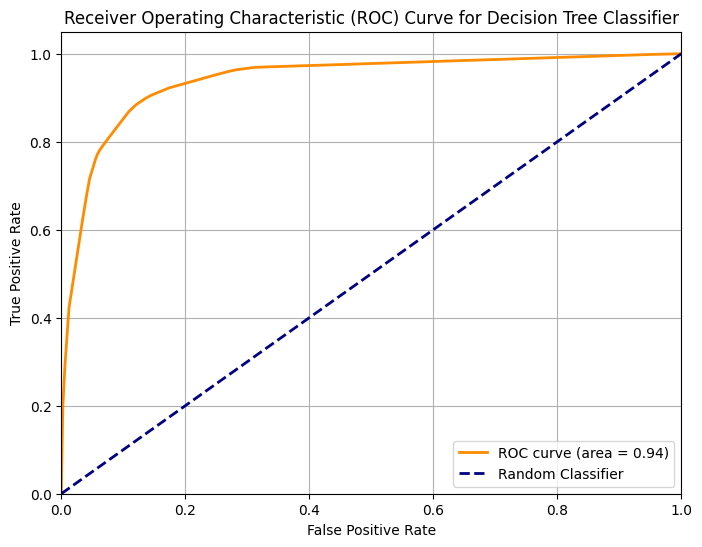

In [51]:
# Get predicted probabilities for the positive class
y_pred_proba_dtclf = dtclassifier.predict_proba(X_train)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba_dtclf)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## part 1(c): Gini impurity measure

Visualize the decision tree, and pick three of the leaf nodes in your decision tree visualization.

For each node, calculate the Gini impurity by hand to check against the calculation from scikit-learn. Show the steps of your calculation and the result.

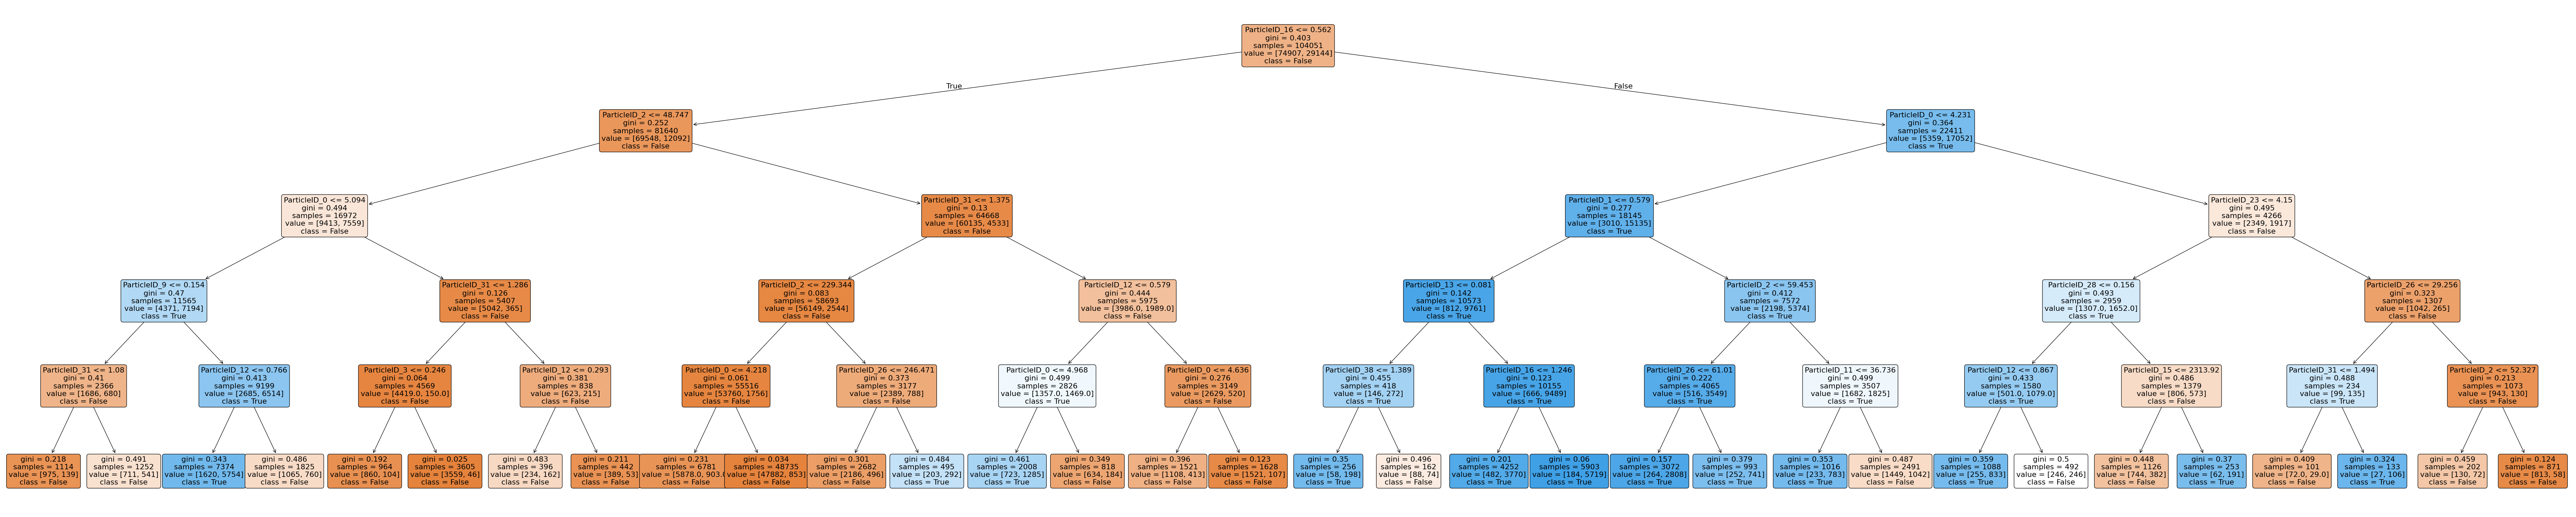

In [61]:
plt.figure(figsize=(100, 20))
plot_tree(
    dtclassifier,
    feature_names=data['feature_names'],
    class_names=["False", "True"],
    filled=True,
    rounded=True,
    fontsize=16
)
plt.show()



**Gini impurity for leaf node with ParticleID_16<=0.562**

$N_{total} = 104051$, $N_{false}= 74907$, $N_{true}= 29144$

$gini = 1 - ((\frac{74907}{104051})^2 + (\frac{29144}{104051})^2) = 0.4032821883883695$ -> same as in plot


**Gini impurity for leaf node with ParticleID_2<=48.747**

$N_{total} = 81640$, $N_{false}= 69548$, $N_{true}= 12092$

$gini = 1 - ((\frac{69548}{81640})^2 + (\frac{12092}{81640})^2) = 0.25235202119413347$ -> same as in plot

**Gini impurity for leaf node with ParticleID_0<=5.094**

$N_{total} = 16972$, $N_{false}= 9413$, $N_{true}= 7559$

$gini = 1 - ((\frac{9413}{16972})^2 + (\frac{7559}{16972})^2) = 0.494033448167585$ -> same as in plot

# Exercise 2: Backpropagation (30 points)

In this exercise you will gain some experience with the backpropagation equations and the numerical calculations of the gradient.



## part 2(a): Backpropagation theory (15 points)

Complete the proofs of [Nielsen's equations BP3 and BP4](http://neuralnetworksanddeeplearning.com/chap2.html#proof_of_the_four_fundamental_equations_(optional)).

In Nielsen's notation (but with layer numbers written in parenthesis for clarity):
$$
\begin{align}
\frac{\partial C}{\partial b_j^{(l)}} &= \delta_j^{(l)} & \quad \quad \text{(BP3)} \\
\frac{\partial C}{\partial w_{jk}^{(l)}} &= a_k^{(l-1)} \delta_j^{(l)} & \quad \quad \text{(BP4)}
\end{align}
$$
where $C$ is the cost function (loss function), $w$ and $b$ are weights and biases, $a$ is the post-activation output for the layer, and $\delta$ is the error of a single neuron.

## part 2(b): Numerical calculation (15 points)

Consider a single perceptron node with 1-dimensional input $x$. The weight and bias of the node are $w=0.5$ and $b=0.1$. We use the ReLU activation function on the output of the node and the mean square error loss function.

If the data input and target are $x=1, y=1$:
- What is the loss function value?
- What is the gradient $\partial L/\partial w$?
- What is the gradient $\partial L/\partial b$?

You can do this by hand. Show your work, and feel free to check your answer with some code.




# Exercise 3: Deep Neural Networks (40 points)

In this exercise we will train a deep neural network for neutrino experiment data from [the MiniBOONE experiment](https://www.fnal.gov/pub/science/experiments/intensity/miniboone.html).

The goal is similar to Exercise 1 above: prepare a binary classification to distinguish electron neutrinos (signal) from muon neutrinos (background).

In this exercise, you will set up a neural network model using PyTorch and train it using the MiniBOONE training data, then test it on the testing data.

## part 3(a) (20 points): DNN with tanh activation

Implement a deep neural network (at least 1 hidden layer between the input and output layers) to classify events as electron neutrinos (signal) or muon neutrinos (background). Use the tanh activation function, except in the output layer.

Here are some starting points for the DNN:
- 3 hidden layers w/ 64 units each
- BCE loss function
- SGD optimizer w/ batch size of 128

You should expect to train for at least 50 epochs.

In [ ]:
# Put code here to implement the DNN to classify neutrino events
# You can use the examples from class and the hands-on notebooks

## part 3(b) (10 points): DNN performance assessment

Calculate the performance of the DNN on the testing data:
- confusion matrix
- ROC curve
- Area Under Curve (AUC)



In [ ]:
# Put code here to assess the DNN performance
# You can use the examples from class and the hands-on notebooks

## part 3(c) (10 points): Change of activation function

Replace the sigmoid activation functions with the ReLU activation functions, in the layers where it is possible.
(Hint: there is one layer where you can't use the ReLU activation function--why not?)

What happens with the training and performance? Can you improve the performance relative to the original training with sigmoid activation functions?

In [ ]:
# Put code here to change the activation functions to sigmoid,
# then retrain and re-assess the performance.
# (It's reasonable to cut-and-paste from the code in part 3(a).)